# Praca magisterska
## Metoda i narzędzie do wydobywania znaczenia z zadanego tekstu i wyszukiwania tekstów o zbliżonym znaczeniu

Proces:
1. Zdobycie danych
2. Czyszczenie
3. Reprezentacja
4. Modelowanie
5. Wykorzystanie

In [1]:
from collections import Counter
import urllib
import codecs
import nltk
import numpy as np 

import pandas as pd

#downloading the webpage
import requests
import datetime

#parsing a page
from bs4 import BeautifulSoup
import re
#presentation handling
from pptx import Presentation

#file handling
from os import listdir

#WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import string

import warnings  
warnings.filterwarnings('ignore')

## Wczytywanie danych
### Czytania

In [2]:
df_readings = pd.read_csv('../CSV/df_readings.csv', header=0, index_col=0, sep=';')
df_readings.head()

,Dzień tygodnia,Pierwsze czytanie,Psalm_ref,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia
2019-02-03,Sunday,Za panowania Jozjasza Pan skierował do mnie na...,"Będę wysławiał pomoc Twoją, Panie","W Tobie, Panie, ucieczka moja, niech wstydu ni...","Starajcie się o większe dary, a ja wam wskażę ...","Pan posłał Mnie, abym ubogim niósł dobrą now...","Kiedy Jezus przyszedł do Nazaretu, przemówił d..."
2019-02-02,Saturday,"To mówi Pan Bóg: ""Oto Ja wyślę anioła mego, ab...","Pan Bóg Zastępów, On jest Królem chwały","Bramy, podnieście swe szczyty, unieście się, o...","Ponieważ dzieci uczestniczą we krwi i ciele, d...",Światło na oświecenie pogan i chwała ludu Tw...,Gdy upłynęły dni oczyszczenia Maryi według Pra...
2019-02-01,Friday,"Przypomnijcie sobie dawniejsze dni, kiedy to p...",Zbawienie prawych pochodzi od Pana,"Miej ufność w Panu i czyń to, co dobre, a będz...",None,"Wysławiam Cię, Ojcze, Panie nieba i ziemi, ż...","Jezus mówił do tłumów: ""Z królestwem Bożym dzi..."
2019-01-31,Thursday,"Bracia, mamy pewność, iż wejdziemy do Miejsca ...","Oto lud wierny, szukający Boga","Do Pana należy ziemia i wszystko, co ją napełn...",None,", 105) Twoje słowo jest pochodnią dla stóp mo...","Jezus mówił ludowi: ""Czy po to wnosi się świat..."
2019-01-30,Wednesday,Każdy kapłan Starego Testamentu staje codzienn...,"Jesteś kapłanem, tak jak Melchizedek","Rzekł Pan do Pana mego: ""Siądź po mojej prawic...",None,"Ziarnem jest słowo Boże, a siewcą jest Chrys...",Jezus znowu zaczął nauczać nad jeziorem i bard...


In [3]:
df_cleaned = df_readings.dropna()

In [4]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, 2019-02-03 to 2018-09-27
Data columns (total 7 columns):
Dzień tygodnia            128 non-null object
Pierwsze czytanie         128 non-null object
Psalm_ref                 128 non-null object
Psalm                     128 non-null object
Drugie czytanie           128 non-null object
Werset przed Ewangelią    128 non-null object
Ewangelia                 128 non-null object
dtypes: object(7)
memory usage: 8.0+ KB


In [5]:
df_readings['Ewangelia'][0]

'Kiedy Jezus przyszedł do Nazaretu, przemówił do ludu w synagodze: "Dziś spełniły się te słowa Pisma, które słyszeliście". A wszyscy przyświadczali Mu i dziwili się pełnym łaski słowom, które płynęły z ust Jego. I mówili: "Czy nie jest to syn Józefa?" Wtedy rzekł do nich: "Z pewnością powiecie Mi to przysłowie: Lekarzu, ulecz samego siebie; dokonajże i tu, w swojej ojczyźnie, tego, co wydarzyło się, jak słyszeliśmy, w Kafarnaum". I dodał: "Zaprawdę, powiadam wam: Żaden prorok nie jest mile widziany w swojej ojczyźnie. Naprawdę, mówię wam: Wiele wdów było w Izraelu za czasów Eliasza, kiedy niebo pozostawało zamknięte przez trzy lata i sześć miesięcy, tak że wielki głód panował w całym kraju; a Eliasz do żadnej z nich nie został posłany, tylko do owej wdowy w Sarepcie Sydońskiej. I wielu trędowatych było w Izraelu za proroka Elizeusza, a żaden z nich nie został oczyszczony, tylko Syryjczyk Naaman". Na te słowa wszyscy w synagodze unieśli się gniewem. Porwawszy się z miejsc, wyrzucili Go 

### Piosenki

In [6]:
df_songs = pd.read_csv('../CSV/df_songs.csv', header=0, index_col=0)
df_songs.head()

,Tytuł,Tekst
0,Abba Ojcze,Ty wyzwoliłeś nas Panie z kajdan i samych sie...
1,Alleluja (Niech zabrzmi Panu),"Alleluja, Alleluja, Alleluja, Alleluja. Nie..."
2,"Alleluja, Alleluja, Amen Amen, Alleluja","Alleluja, Alleluja, Amen, Amen, Alleluja. ..."
3,"Blisko, blisko, blisko jesteś","Blisko, blisko, blisko Jesteś Panie mój Blisk..."
4,Bo góry mogą ustąpić,Bo góry mogą ustąpić i pagórki się zachwiać. ...


In [7]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 186
Data columns (total 2 columns):
Tytuł    187 non-null object
Tekst    187 non-null object
dtypes: object(2)
memory usage: 4.4+ KB


## Pobieranie danych
### Piosenki

#### Inicjalizacja pd.DataFrame dla piosenek

In [8]:
df_p = pd.DataFrame(data=None, index=None, #pd.date_range('1/1/2019', periods=10, freq='D'), 
                  columns = ["Tytuł","Tekst"])
df_p.head()

,Tytuł,Tekst


In [9]:
def parse_presentation(presentation_path):
    prs = Presentation(presentation_path)
    text = str()
    for slide in prs.slides:
        for shape in slide.shapes:
            if not shape.has_text_frame:
                continue
            for paragraph in shape.text_frame.paragraphs:
                for run in paragraph.runs:
                    text = text + run.text + ' '
    return text

In [10]:
def clean_song(text):
    cleaner = re.compile('Ref\.|REFREN|[0-9]\.|\/x2')
    cleantext = re.sub(cleaner, '',text)
    #tokens = re.split('\W+', text)
    #cleaned = " ".join([word.lower() for word in cleantext if word.isalpha()])
    return cleantext

In [13]:
i=0
for file in listdir('../prezentacje'):
    path = '../prezentacje/' + file
    song_name = file[:-5]
    text = parse_presentation(path)
    df_p.loc[i] = [song_name, clean_song(text)]
    i=i+1
print(i)

186


In [14]:
path = '../prezentacje/Abba Ojcze.pptx'
song = parse_presentation(path)
print(song)

Ty wyzwoliłeś nas Panie  z kajdan i samych siebie,  a Chrystus stając się bratem  nauczył nas wołać do Ciebie:  Abba Ojcze! Abba Ojcze! Abba Ojcze! 2. Bo Kościół jak drzewo życia w wieczności zapuszcza korzenie, przenika naszą codzienność i pokazuje nam Ciebie. Abba Ojcze! Abba Ojcze! Abba Ojcze! 3. Bóg hojnym Dawcą jest życia, on wyswobodził nas z śmierci i przygarniając do siebie uczynił swoimi dziećmi. Abba Ojcze! Abba Ojcze! Abba Ojcze! 4. Wszyscy jesteśmy braćmi, jesteśmy jedną rodziną. Tej prawdy nic już nie zaćmi i teraz jest jej godzina. Abba Ojcze! Abba Ojcze! Abba Ojcze! 


In [15]:
df_p.head()

,Tytuł,Tekst
0,Abba Ojcze,Ty wyzwoliłeś nas Panie z kajdan i samych sie...
1,Alleluja (Niech zabrzmi Panu),"Alleluja, Alleluja, Alleluja, Alleluja. Nie..."
2,"Alleluja, Alleluja, Amen Amen, Alleluja","Alleluja, Alleluja, Amen, Amen, Alleluja. ..."
3,"Blisko, blisko, blisko jesteś","Blisko, blisko, blisko Jesteś Panie mój Blisk..."
4,Bo góry mogą ustąpić,Bo góry mogą ustąpić i pagórki się zachwiać. ...


In [16]:
text = df_p.iloc[2]['Tekst']
text

' Alleluja, Alleluja,  Amen, Amen, Alleluja.   Pokłońmy się przed Nim –  On naszym Panem jest  Pokłońmy się przed Nim –  On naszym Panem Amen, Amen, Alleluja.  Alleluja, Alleluja,  Amen, Amen, Alleluja.   Jezus Chrystus zmartwychwstał –  On naszym Panem jest  Jezus Chrystus zmartwychwstał –  On naszym Panem Amen, Amen, Alleluja.  Alleluja, Alleluja,  Amen, Amen, Alleluja.   Radujmy się bracia –  On naszym Panem jest  Radujmy się wszyscy –  On naszym Panem. Amen, Amen, Alleluja.  Alleluja, Alleluja,  Amen, Amen, Alleluja.   Posyła nam Ducha –  On naszym Panem jest  Posyła nam Ducha –  On naszym Panem. Amen, Amen, Alleluja. '

In [17]:
df_p.to_csv(path_or_buf= '../CSV/df_songs.csv', header=df_p.columns)

## Czytania danego dnia

In [18]:
def get_readings(address, day_name):
    page = requests.get(address)
    soup = BeautifulSoup(page.content, 'html.parser')
    #print(soup.prettify()) 
    #Exception handling for more readings
    try:
        #section = list(soup.children)[9]
        #section_content = section.find_all('p')   
        section = list(soup.children)
        #if len(section) != 30:
            #print(len(section), address, day_name)
        section_content1 = section[2].find_all('p')
        if ((day_name == 'Sunday') or (len(section) in [32,34])):
            section_content2 = section[6]
            section_content3 = section[8]
            section_content4 = section[12]
        else:
            section_content2 = None
            section_content3 = section[4]
            section_content4 = section[8]
            
        pierwsze_czytanie = str(section_content1[6])
        drugie_czytanie = str(section_content2)
        tekst_przed_ewangelia = str(section_content3)
        psalm_ref = str(section_content1[7])
        psalm = ""
        i = 8
        while i < len(section_content1):
            psalm += str(section_content1[i])
            i += 1
        ewangelia = str(section_content4)
        document = [pierwsze_czytanie,psalm_ref,psalm, drugie_czytanie, tekst_przed_ewangelia, ewangelia]
        return document
    except:
        pass
        #section = soup.find_all('section')[0]
        #section_content =section.find_all('p')

In [19]:
#czytanie na dziś
now = datetime.datetime.now()
today = datetime.date.today()
year = str(now.year)
month = str(now.month)
if len(month) == 1:
    month = "0" + month

day = str(now.day)
if len(day) == 1:
    day = "0" + day

ymd = year+month+day
today_name = now.strftime("%A")
day_name = today_name
#today_name = 'Sunday'

address = "http://mateusz.pl/czytania/" + year + "/" + ymd + ".html"
#address = "http://mateusz.pl/czytania/2018/20181021.html" #niedziela
doc = get_readings(address, today)
#print(address)

In [20]:
today_name

'Sunday'

In [21]:
doc[5] #ewangelia

'<p>\r\n                        (Łk 10,1-12.17-20) <br>\r\n                        Jezus wyznaczył jeszcze innych siedemdziesięciu dwóch uczniów i wysłał ich po dwóch przed sobą do każdego miasta i miejscowości, dokąd sam przyjść zamierzał. Powiedział też do nich: ”Żniwo wprawdzie wielkie, ale robotników mało; proście więc Pana żniwa, żeby wyprawił robotników na swoje żniwo. Idźcie, oto was posyłam jak owce między wilki. Nie noście z sobą trzosa ani torby, ani sandałów; i nikogo w drodze nie pozdrawiajcie. Gdy do jakiego domu wejdziecie, najpierw mówcie: "Pokój temu domowi". Jeśli tam mieszka człowiek godny pokoju, wasz pokój spocznie na nim; jeśli nie, powróci do was. W tym samym domu zostańcie, jedząc i pijąc, co mają; bo zasługuje robotnik na swą zapłatę. Nie przechodźcie z domu do domu. Jeśli do jakiego miasta wejdziecie i przyjmą was, jedzcie, co Wam podadzą; uzdrawiajcie chorych, którzy tam są, i mówcie im: "Przybliżyło się do was królestwo Boże". Lecz jeśli do jakiego miasta wej

In [22]:
def get_adresses(n):
    adresses = []
    date_list = [base - datetime.timedelta(days=x) for x in range(0, n)]
    dates_cleaned = [str(x).replace('-','') for x in date_list]
    for date in dates_cleaned:
        ymd = date
        address = "http://mateusz.pl/czytania/" + ymd[:4]+ "/" + ymd + ".html"
        adresses.append(address)
    return adresses

In [23]:
#get_adresses(140)

#### Inicjalizacja pd.DataFrame dla czytań

In [24]:
df_raw = pd.DataFrame(data=None, index=None, #pd.date_range('1/1/2019', periods=10, freq='D'), 
                  columns = ["Dzień tygodnia","Pierwsze czytanie", "Psalm_ref", "Psalm", "Drugie czytanie", 
                                                    "Werset przed Ewangelią", "Ewangelia"])
df_raw.head()

,Dzień tygodnia,Pierwsze czytanie,Psalm_ref,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia


## Noise removal // Cleaning

In [25]:
#first phase - for easy reading
def clean_html(raw):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner, '', raw)
    return cleantext

def clean_proverbs (raw):
    cleaner = re.compile('\([^)]*\)')
    cleantext = re.sub(cleaner, '',raw)
    return cleantext

def clean_indent(raw):
    cleaner = re.compile('^\s+')
    cleantext = re.sub(cleaner, '',raw)
    return cleantext

def clean_rest(text):
    cleaner = re.compile('\\r\\n\s+')
    cleantext = re.sub(cleaner, '',text)
    return cleantext

def clean_rest2(text):
    cleaner = re.compile('(\\r\\n)')
    cleantext = re.sub(cleaner, ' ',text)
    return cleantext

def clean_carriage(text):
    cleaner = re.compile('(.*)\n')
    cleantext = re.sub(cleaner, '',text)
    return cleantext

def clean_psalmus(text):
    cleaner = re.compile('Aklamacja|REFREN\:\s|Bracia\:\s')
    cleantext = re.sub(cleaner, '',text)
    return cleantext

def clean_text(raw):
    text = clean_html(raw)
    text = clean_proverbs(text)
    text = clean_indent(text)
    text = clean_rest(text)
    text = clean_rest2(text)
    text = clean_carriage(text)
    text = clean_psalmus(text)
    return text


In [26]:
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

In [27]:
n=130
base = datetime.date.today()
date_list = [base - datetime.timedelta(days=x) for x in range(0, n)]
#print(date_list)
dates_cleaned = [str(x).replace('-','') for x in date_list]
#print(dates_cleaned)
dates_names = [x.strftime("%A") for x in date_list]
#print(dates_names)
adresses = get_adresses(n)
#print(adresses)

for i in range(n):
        doc = get_readings(adresses[i], dates_names[i])
        #doc_cleaned = [clean_text(str(text)) for text in doc]
        input_row = [dates_names[i]]
        for each in doc: #doc_cleaned:
            input_row.append(each)
        df_raw.loc[date_list[i]] = input_row



In [28]:
df_raw.set_index(pd.Index([str(x) for x in df_raw.index]), inplace=True)

In [29]:
df_raw.tail()

,Dzień tygodnia,Pierwsze czytanie,Psalm_ref,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia
2019-03-04,Monday,"<p>\r\n (Syr 51, 13-20)...","<p>\r\n (Ps 16, 1-2a i ...","<p>Zachowaj mnie, Boże, bo chronię się do Cieb...","<p>\r\n (Flp 3, 8-14) <...","<p>\r\n (J 15, 16) <br>...","<p>\r\n (J 15, 9-17) <b..."
2019-03-03,Sunday,"<p>\r\n (Syr 27, 4-7) <...","<p>\r\n (Ps 92 (91), 2-...","<p>Dobrze jest dziękować Panu,<br/>\r\nśpiewać...","<p>\r\n (1 Kor 15, 54b-...","<p>\r\n (Flp 2, 15d. 16...","<p>\r\n (Łk 6, 39-45) <..."
2019-03-02,Saturday,"<p>\r\n (Syr 17, 1-15) ...","<p>\r\n (Ps 103 (102), ...","<p>Jak ojciec lituje się nad dziećmi,<br/>\r\n...",None,"<p>\r\n (Mt 11, 25) <br...","<p>\r\n (Mk 10, 13-16) ..."
2019-03-01,Friday,"<p>\r\n (Syr 6, 5-17) <...","<p>\r\n (Ps 119 (118), ...","<p>Błogosławiony jesteś, Panie,<br/>\r\nnaucz ...",None,"<p>\r\n (J 17, 17ba) <b...","<p>\r\n (Mk 10, 1-12) <..."
2019-02-28,Thursday,"<p>\r\n (Syr 5, 1-8) <b...","<p>\r\n (Ps 1, 1-2. 3. ...","<p>Szczęśliwy człowiek, który nie idzie za rad...",None,"<p>\r\n (1 Tes 2, 13) <...","<p>\r\n (Mk 9, 41-43. 4..."


In [30]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, 2019-07-07 to 2019-02-28
Data columns (total 7 columns):
Dzień tygodnia            130 non-null object
Pierwsze czytanie         130 non-null object
Psalm_ref                 130 non-null object
Psalm                     130 non-null object
Drugie czytanie           130 non-null object
Werset przed Ewangelią    130 non-null object
Ewangelia                 130 non-null object
dtypes: object(7)
memory usage: 8.1+ KB


In [31]:
df_cleaned = df_raw.copy()

In [32]:
for each in df_cleaned.columns:
    df_cleaned[each] = df_cleaned[each].apply(lambda x: clean_text(x))

In [33]:
df_cleaned.iloc[40][6]

'Jezus powiedział do swoich uczniów: „Teraz idę do Tego, który Mnie posłał, a nikt z was nie pyta Mnie: "Dokąd idziesz?" Ale ponieważ to wam powiedziałem, smutek napełnił wam serce. Jednakże mówię wam prawdę: Pożyteczne jest dla was moje odejście. Bo jeżeli nie odejdę, Pocieszyciel nie przyjdzie do was. A jeżeli odejdę, poślę Go do was. On zaś gdy przyjdzie, przekona świat o grzechu, o sprawiedliwości i o sądzie. O grzechu, bo nie wierzą we Mnie; o sprawiedliwości zaś, bo idę do Ojca i już Mnie nie ujrzycie; wreszcie o sądzie, bo władca tego świata został osądzony”.'

In [34]:
df_cleaned.tail()

,Dzień tygodnia,Pierwsze czytanie,Psalm_ref,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia
2019-03-04,Monday,"Będąc jeszcze młodym, zanim zacząłem podróżowa...","Pan mym dziedzictwem, moim przeznaczeniem","Zachowaj mnie, Boże, bo chronię się do Ciebie,...",Wszystko uznaję za stratę ze względu na najwyż...,"Nie wyście Mnie wybrali, ale Ja was wybrałem, ...","Jezus powiedział do swoich uczniów:"" Jak Mnie ..."
2019-03-03,Sunday,"Gdy sitem się przesiewa, zostają odpadki, podo...","Dobrze jest śpiewać Tobie, Panie Boże","Dobrze jest dziękować Panu, śpiewać Twojemu im...","Kiedy już to, co śmiertelne, przyodzieje się w...","Jawicie się jako źródło światła w świecie, trz...","Jezus opowiedział uczniom przypowieść: ""Czy mo..."
2019-03-02,Saturday,Pan stworzył człowieka z ziemi i znów kazał mu...,Bóg jest łaskawy dla swoich czcicieli,"Jak ojciec lituje się nad dziećmi, tak Pan się...",None,"Wysławiam Cię, Ojcze, Panie nieba i ziemi, że ...","Przynosili Jezusowi dzieci, żeby ich dotknął; ..."
2019-03-01,Friday,"Miła mowa przyciąga przyjaciół, a język uprzej...","Prowadź mnie, Panie, ścieżką Twych przykazań","Błogosławiony jesteś, Panie, naucz mnie swoich...",None,"Słowo Twoje, Panie, jest prawdą, uświęć nas w ...",Jezus przyszedł w granice Judei i Zajordania. ...
2019-02-28,Thursday,"Nie polegaj na swych bogactwach i nie mów: ""On...","Szczęśliwy człowiek, który ufa Panu","Szczęśliwy człowiek, który nie idzie za radą w...",None,"Przyjmijcie słowo Boże nie jako słowo ludzkie,...","Jezus powiedział do swoich uczniów: ""Kto wam p..."


In [36]:
df_raw.loc['2019-06-19']['Psalm']

'<p>Błogosławiony człowiek, który boi się Pana<br/>\r\ni wielką radość znajduje w Jego przykazaniach.<br/>\r\nPotomstwo jego będzie potężne na ziemi,<br/>\r\ndostąpi błogosławieństwa pokolenie prawych.</p><p>Dobrobyt i bogactwo będą w jego domu,<br/>\r\na jego sprawiedliwość będzie trwała zawsze.<br/>\r\nOn wschodzi w ciemnościach jak światło dla prawych,<br/>\r\nłagodny, miłosierny i sprawiedliwy.</p><p>Rozdaje i obdarza ubogich,<br/>\r\njego sprawiedliwość będzie trwała zawsze,<br/>\r\nwywyższona z chwałą<br/>\r\nbędzie jego potęga.</p>'

In [37]:
df_cleaned.loc['2019-06-19']['Psalm']

'Błogosławiony człowiek, który boi się Pana i wielką radość znajduje w Jego przykazaniach. Potomstwo jego będzie potężne na ziemi, dostąpi błogosławieństwa pokolenie prawych.Dobrobyt i bogactwo będą w jego domu, a jego sprawiedliwość będzie trwała zawsze. On wschodzi w ciemnościach jak światło dla prawych, łagodny, miłosierny i sprawiedliwy.Rozdaje i obdarza ubogich, jego sprawiedliwość będzie trwała zawsze, wywyższona z chwałą będzie jego potęga.'

In [38]:
df_cleaned.index[1]

'2019-07-06'

In [39]:
#df_cleaned.to_csv(path_or_buf= 'df_readings.csv', header=df_cleaned.columns, sep=';')

In [40]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, 2019-07-07 to 2019-02-28
Data columns (total 7 columns):
Dzień tygodnia            130 non-null object
Pierwsze czytanie         130 non-null object
Psalm_ref                 130 non-null object
Psalm                     130 non-null object
Drugie czytanie           130 non-null object
Werset przed Ewangelią    130 non-null object
Ewangelia                 130 non-null object
dtypes: object(7)
memory usage: 13.1+ KB


In [42]:
text = df_cleaned.loc['2019-06-19']['Ewangelia']
print(text)

Jezus powiedział do swoich uczniów: „Strzeżcie się, żebyście uczynków pobożnych nie wykonywali przed ludźmi po to, aby was widzieli; inaczej nie będziecie mieli nagrody u Ojca waszego, który jest w niebie. Kiedy więc dajesz jałmużnę, nie trąb przed sobą, jak obłudnicy czynią w synagogach i na ulicach, aby ich ludzie chwalili. Zaprawdę powiadam wam: ci otrzymali już swoją nagrodę. Kiedy zaś ty dajesz jałmużnę, niech nie wie lewa twoja ręka, co czyni prawa, aby twoja jałmużna pozostała w ukryciu. A Ojciec twój który widzi w ukryciu, odda tobie. Gdy się modlicie, nie bądźcie jak obłudnicy. Oni lubią w synagogach i na rogach ulic wystawać i modlić się, żeby się ludziom pokazać. Zaprawdę powiadam wam: otrzymali już swoją nagrodę. Ty zaś gdy chcesz się modlić, wejdź do swej izdebki, zamknij drzwi i módl się do Ojca twego, który jest w ukryciu. A Ojciec twój, który widzi w ukryciu, odda tobie. Kiedy pościcie, nie bądźcie posępni jak obłudnicy. Przybierają oni wygląd ponury, aby pokazać ludzio

In [43]:
text

'Jezus powiedział do swoich uczniów: „Strzeżcie się, żebyście uczynków pobożnych nie wykonywali przed ludźmi po to, aby was widzieli; inaczej nie będziecie mieli nagrody u Ojca waszego, który jest w niebie. Kiedy więc dajesz jałmużnę, nie trąb przed sobą, jak obłudnicy czynią w synagogach i na ulicach, aby ich ludzie chwalili. Zaprawdę powiadam wam: ci otrzymali już swoją nagrodę. Kiedy zaś ty dajesz jałmużnę, niech nie wie lewa twoja ręka, co czyni prawa, aby twoja jałmużna pozostała w ukryciu. A Ojciec twój który widzi w ukryciu, odda tobie. Gdy się modlicie, nie bądźcie jak obłudnicy. Oni lubią w synagogach i na rogach ulic wystawać i modlić się, żeby się ludziom pokazać. Zaprawdę powiadam wam: otrzymali już swoją nagrodę. Ty zaś gdy chcesz się modlić, wejdź do swej izdebki, zamknij drzwi i módl się do Ojca twego, który jest w ukryciu. A Ojciec twój, który widzi w ukryciu, odda tobie. Kiedy pościcie, nie bądźcie posępni jak obłudnicy. Przybierają oni wygląd ponury, aby pokazać ludzi

### Tłumaczenie

In [45]:
from googletrans import Translator 

In [46]:
t = Translator()
#t.translate(text)

In [44]:
df_eng = pd.read_csv('../CSV/df_eng_readings.csv', header=0, index_col=0)
df_eng.tail()

,Dzień tygodnia,Pierwsze czytanie,Psalm_ref,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia
2019-01-17,Thursday,"Proceed, as the Holy Spirit says: ""Today, if y...","Hear not the hearts of the Lord, harden your h...","Come, let us adore Him, falling on our faces, ...",None,Jesus preached the gospel of the kingdom and h...,"One day, he came to the leper of Jesus and, fa..."
2019-01-16,Wednesday,Because children have a share in their blood a...,God remembers his covenant,"Praise the Lord, call upon His name, preach Hi...",None,"My sheep hear my voice, I know them, and they ...",After leaving the synagogue Jesus came with Ja...
2019-01-15,Tuesday,God has not surrendered to the angels of the f...,You gave the Son authority over his work,"O Lord, our Lord, how wonderful is Your name t...",None,Accept the word of God not as a human word but...,"In Capernaum, Jesus entered the synagogue on t..."
2019-01-14,Monday,Many times and in various ways God spoke to ou...,"Pay homage to Him, all angels","The Lord reigns, be glad, earth, rejoice, many...",None,The kingdom of God is close. Repent and believ...,"When John was imprisoned, Jesus came to Galile..."
2019-01-13,Sunday,"This is what the Lord God says: ""Behold, I wil...","Lord God of hosts, He is the King of glory","Gates, raise your peaks, stand out, eternal do...",Because children are involved in blood and bod...,Light on the enlightenment of the Gentiles and...,When the days of the purification of Mary acco...


In [47]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2019-02-01 to 2019-01-13
Data columns (total 7 columns):
Dzień tygodnia            20 non-null object
Pierwsze czytanie         20 non-null object
Psalm_ref                 20 non-null object
Psalm                     20 non-null object
Drugie czytanie           20 non-null object
Werset przed Ewangelią    20 non-null object
Ewangelia                 20 non-null object
dtypes: object(7)
memory usage: 1.2+ KB


### Tłumaczenie df_cleaned

In [48]:
df=pd.DataFrame(index=df_cleaned.index)
df.head()

""
2019-07-07
2019-07-06
2019-07-05
2019-07-04
2019-07-03


In [49]:
df['Ewangelia'] = df_cleaned['Ewangelia'].apply(lambda x: t.translate(x))

In [50]:
df['Ewangelia'] = df['Ewangelia'].apply(lambda x: x.text)

In [51]:
df.head()

,Ewangelia
2019-07-07,Jesus appointed another seventy-two disciples ...
2019-07-06,"John's disciples came to Jesus and asked, ""Why..."
2019-07-05,"Departing from Capernaum, Jesus saw a man sitt..."
2019-07-04,"Jesus got into the boat, crossed over and came..."
2019-07-03,"Thomas, one of the Twelve, called Didymus, was..."


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, 2019-07-07 to 2019-02-28
Data columns (total 1 columns):
Ewangelia    130 non-null object
dtypes: object(1)
memory usage: 7.0+ KB


In [32]:
df_eng.tail()

,Dzień tygodnia,Pierwsze czytanie,Psalm_ref,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia
2019-01-17,Thursday,"Proceed, as the Holy Spirit says: ""Today, if y...","Hear not the hearts of the Lord, harden your h...","Come, let us adore Him, falling on our faces, ...",None,Jesus preached the gospel of the kingdom and h...,"One day, he came to the leper of Jesus and, fa..."
2019-01-16,Wednesday,Because children have a share in their blood a...,God remembers his covenant,"Praise the Lord, call upon His name, preach Hi...",None,"My sheep hear my voice, I know them, and they ...",After leaving the synagogue Jesus came with Ja...
2019-01-15,Tuesday,God has not surrendered to the angels of the f...,You gave the Son authority over his work,"O Lord, our Lord, how wonderful is Your name t...",None,Accept the word of God not as a human word but...,"In Capernaum, Jesus entered the synagogue on t..."
2019-01-14,Monday,Many times and in various ways God spoke to ou...,"Pay homage to Him, all angels","The Lord reigns, be glad, earth, rejoice, many...",None,The kingdom of God is close. Repent and believ...,"When John was imprisoned, Jesus came to Galile..."
2019-01-13,Sunday,"This is what the Lord God says: ""Behold, I wil...","Lord God of hosts, He is the King of glory","Gates, raise your peaks, stand out, eternal do...",Because children are involved in blood and bod...,Light on the enlightenment of the Gentiles and...,When the days of the purification of Mary acco...


In [92]:
#zapis do CSV
#df_eng.to_csv(path_or_buf= '../CSV/df_eng_readings.csv', header=df_eng.columns, sep=;)
#df.to_csv(path_or_buf='../CSV/df_eng_gospel.csv', header=df.columns)

### Tłumaczenie df_p

In [12]:
df_songs['Eng'] = df_songs['Eng'].apply(lambda x: x.text)

In [13]:
df_songs.head()

,Tytuł,Tekst,Eng
0,Abba Ojcze,Ty wyzwoliłeś nas Panie z kajdan i samych sie...,"You delivered us from chains and ourselves, an..."
1,Alleluja (Niech zabrzmi Panu),"Alleluja, Alleluja, Alleluja, Alleluja. Nie...","Alleluia, Alleluia, Alleluia, Alleluia. Let th..."
2,"Alleluja, Alleluja, Amen Amen, Alleluja","Alleluja, Alleluja, Amen, Amen, Alleluja. ...","Alleluia, Alleluia, Amen, Amen, Alleluia. Let ..."
3,"Blisko, blisko, blisko jesteś","Blisko, blisko, blisko Jesteś Panie mój Blisk...","Close, close, close You are my Lord, Close to ..."
4,Bo góry mogą ustąpić,Bo góry mogą ustąpić i pagórki się zachwiać. ...,Because the mountains can give way and the hil...


In [15]:
df_songs.to_csv(path_or_buf='../CSV/df_eng_songs.csv', header=df_songs.columns)

In [53]:
#error w wyniku limitu dziennego
df_p_eng = df_p.copy()
for each in df_p_eng.columns:
    df_p_eng[each] = df_p_eng[each].apply(lambda x: str(translator.translate(x).text))

NameError: name 'translator' is not defined

In [54]:
df_p_eng.head()

,Tytuł,Tekst
0,Abba Ojcze,Ty wyzwoliłeś nas Panie z kajdan i samych sie...
1,Alleluja (Niech zabrzmi Panu),"Alleluja, Alleluja, Alleluja, Alleluja. Nie..."
2,"Alleluja, Alleluja, Amen Amen, Alleluja","Alleluja, Alleluja, Amen, Amen, Alleluja. ..."
3,"Blisko, blisko, blisko jesteś","Blisko, blisko, blisko Jesteś Panie mój Blisk..."
4,Bo góry mogą ustąpić,Bo góry mogą ustąpić i pagórki się zachwiać. ...


In [55]:
#zapis do CSV
#df_p_eng.to_csv(path_or_buf= '../CSV/df_eng_songs.csv', header=df_p_eng.columns)

## Tokenization & Segmentation

In [56]:
sentences = nltk.sent_tokenize(text)
sentences[:5]

['Jezus powiedział do swoich uczniów: „Strzeżcie się, żebyście uczynków pobożnych nie wykonywali przed ludźmi po to, aby was widzieli; inaczej nie będziecie mieli nagrody u Ojca waszego, który jest w niebie.',
 'Kiedy więc dajesz jałmużnę, nie trąb przed sobą, jak obłudnicy czynią w synagogach i na ulicach, aby ich ludzie chwalili.',
 'Zaprawdę powiadam wam: ci otrzymali już swoją nagrodę.',
 'Kiedy zaś ty dajesz jałmużnę, niech nie wie lewa twoja ręka, co czyni prawa, aby twoja jałmużna pozostała w ukryciu.',
 'A Ojciec twój który widzi w ukryciu, odda tobie.']

In [57]:
tokens = nltk.word_tokenize(text)
lower_tokens = [t.lower() for t in tokens]
print(lower_tokens)

['jezus', 'powiedział', 'do', 'swoich', 'uczniów', ':', '„', 'strzeżcie', 'się', ',', 'żebyście', 'uczynków', 'pobożnych', 'nie', 'wykonywali', 'przed', 'ludźmi', 'po', 'to', ',', 'aby', 'was', 'widzieli', ';', 'inaczej', 'nie', 'będziecie', 'mieli', 'nagrody', 'u', 'ojca', 'waszego', ',', 'który', 'jest', 'w', 'niebie', '.', 'kiedy', 'więc', 'dajesz', 'jałmużnę', ',', 'nie', 'trąb', 'przed', 'sobą', ',', 'jak', 'obłudnicy', 'czynią', 'w', 'synagogach', 'i', 'na', 'ulicach', ',', 'aby', 'ich', 'ludzie', 'chwalili', '.', 'zaprawdę', 'powiadam', 'wam', ':', 'ci', 'otrzymali', 'już', 'swoją', 'nagrodę', '.', 'kiedy', 'zaś', 'ty', 'dajesz', 'jałmużnę', ',', 'niech', 'nie', 'wie', 'lewa', 'twoja', 'ręka', ',', 'co', 'czyni', 'prawa', ',', 'aby', 'twoja', 'jałmużna', 'pozostała', 'w', 'ukryciu', '.', 'a', 'ojciec', 'twój', 'który', 'widzi', 'w', 'ukryciu', ',', 'odda', 'tobie', '.', 'gdy', 'się', 'modlicie', ',', 'nie', 'bądźcie', 'jak', 'obłudnicy', '.', 'oni', 'lubią', 'w', 'synagogach', '

## Normalization / Preprocessing

#### Lemmatyzacja (lemmatisation) 
Algorytm znajdowania lemmy, formy podstawowej wyrazu w obszarze części mowy którą reprezentuje. Inaczej: wyszukiwanie formy kanonicznej leksemu. W komputerowej analizie języka naturalnego lemmatyzacja jest operacją bardziej precyzyjną niż stemmatyzacja. 

#### Stemmatyzacja (stemming) 
Sprowadzenie wyrazu reprezentującego dowolną część mowy do stemu, rdzenia postaci źródłowej, najczęściej rzeczownika, bądź niekiedy nawet sekwencji znaków nie mającej samodzielnego znaczenia w języku naturalnym. 

In [58]:
# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]
print(alpha_only)

['jezus', 'powiedział', 'do', 'swoich', 'uczniów', 'strzeżcie', 'się', 'żebyście', 'uczynków', 'pobożnych', 'nie', 'wykonywali', 'przed', 'ludźmi', 'po', 'to', 'aby', 'was', 'widzieli', 'inaczej', 'nie', 'będziecie', 'mieli', 'nagrody', 'u', 'ojca', 'waszego', 'który', 'jest', 'w', 'niebie', 'kiedy', 'więc', 'dajesz', 'jałmużnę', 'nie', 'trąb', 'przed', 'sobą', 'jak', 'obłudnicy', 'czynią', 'w', 'synagogach', 'i', 'na', 'ulicach', 'aby', 'ich', 'ludzie', 'chwalili', 'zaprawdę', 'powiadam', 'wam', 'ci', 'otrzymali', 'już', 'swoją', 'nagrodę', 'kiedy', 'zaś', 'ty', 'dajesz', 'jałmużnę', 'niech', 'nie', 'wie', 'lewa', 'twoja', 'ręka', 'co', 'czyni', 'prawa', 'aby', 'twoja', 'jałmużna', 'pozostała', 'w', 'ukryciu', 'a', 'ojciec', 'twój', 'który', 'widzi', 'w', 'ukryciu', 'odda', 'tobie', 'gdy', 'się', 'modlicie', 'nie', 'bądźcie', 'jak', 'obłudnicy', 'oni', 'lubią', 'w', 'synagogach', 'i', 'na', 'rogach', 'ulic', 'wystawać', 'i', 'modlić', 'się', 'żeby', 'się', 'ludziom', 'pokazać', 'zapra

In [61]:
polish_stops = codecs.open("../polishStopWords",'r','utf-8')
#stopwords = nltk.corpus.stopwords.words('english')
stopwords = polish_stops.read().split('\n')
polish_stops.close()

In [62]:
# Remove all stop words: no_stops
no_stops = [t for t in alpha_only if t not in stopwords]
print(no_stops)

['jezus', 'powiedział', 'swoich', 'uczniów', 'strzeżcie', 'żebyście', 'uczynków', 'pobożnych', 'wykonywali', 'ludźmi', 'widzieli', 'inaczej', 'będziecie', 'mieli', 'nagrody', 'ojca', 'waszego', 'niebie', 'dajesz', 'jałmużnę', 'trąb', 'obłudnicy', 'czynią', 'synagogach', 'ulicach', 'ludzie', 'chwalili', 'zaprawdę', 'powiadam', 'otrzymali', 'swoją', 'nagrodę', 'dajesz', 'jałmużnę', 'wie', 'lewa', 'ręka', 'czyni', 'prawa', 'jałmużna', 'pozostała', 'ukryciu', 'ojciec', 'widzi', 'ukryciu', 'odda', 'modlicie', 'bądźcie', 'obłudnicy', 'lubią', 'synagogach', 'rogach', 'ulic', 'wystawać', 'modlić', 'ludziom', 'pokazać', 'zaprawdę', 'powiadam', 'otrzymali', 'swoją', 'nagrodę', 'chcesz', 'modlić', 'wejdź', 'swej', 'izdebki', 'zamknij', 'drzwi', 'módl', 'ojca', 'twego', 'ukryciu', 'ojciec', 'widzi', 'ukryciu', 'odda', 'pościcie', 'bądźcie', 'posępni', 'obłudnicy', 'przybierają', 'wygląd', 'ponury', 'pokazać', 'ludziom', 'poszczą', 'zaprawdę', 'powiadam', 'odebrali', 'swoją', 'nagrodę', 'pościsz', 

In [63]:
#z linkedin
def clean_text2(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [64]:
def clean_text3(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    #text = [ps.stem(word) for word in tokens if word not in stopwords]
    return tokens

#### Stemming

In [65]:
ps = nltk.PorterStemmer()
def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

In [66]:
print(stemming(no_stops))

['jezu', 'powiedział', 'swoich', 'uczniów', 'strzeżci', 'żebyści', 'uczynków', 'pobożnych', 'wykonywali', 'ludźmi', 'widzi', 'inaczej', 'będzieci', 'mieli', 'nagrodi', 'ojca', 'waszego', 'niebi', 'dajesz', 'jałmużnę', 'trąb', 'obłudnici', 'czynią', 'synagogach', 'ulicach', 'ludzi', 'chwalili', 'zaprawdę', 'powiadam', 'otrzymali', 'swoją', 'nagrodę', 'dajesz', 'jałmużnę', 'wie', 'lewa', 'ręka', 'czyni', 'prawa', 'jałmużna', 'pozostała', 'ukryciu', 'ojciec', 'widzi', 'ukryciu', 'odda', 'modlici', 'bądźcie', 'obłudnici', 'lubią', 'synagogach', 'rogach', 'ulic', 'wystawać', 'modlić', 'ludziom', 'pokazać', 'zaprawdę', 'powiadam', 'otrzymali', 'swoją', 'nagrodę', 'chcesz', 'modlić', 'wejdź', 'swej', 'izdebki', 'zamknij', 'drzwi', 'módl', 'ojca', 'twego', 'ukryciu', 'ojciec', 'widzi', 'ukryciu', 'odda', 'pościci', 'bądźcie', 'posępni', 'obłudnici', 'przybierają', 'wygląd', 'ponuri', 'pokazać', 'ludziom', 'poszczą', 'zaprawdę', 'powiadam', 'odebrali', 'swoją', 'nagrodę', 'pościsz', 'namaść', '

#### Lemmatizing

In [67]:
wn = nltk.WordNetLemmatizer()
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

In [68]:
print(lemmatizing(no_stops))

['jezus', 'powiedział', 'swoich', 'uczniów', 'strzeżcie', 'żebyście', 'uczynków', 'pobożnych', 'wykonywali', 'ludźmi', 'widzieli', 'inaczej', 'będziecie', 'mieli', 'nagrody', 'ojca', 'waszego', 'niebie', 'dajesz', 'jałmużnę', 'trąb', 'obłudnicy', 'czynią', 'synagogach', 'ulicach', 'ludzie', 'chwalili', 'zaprawdę', 'powiadam', 'otrzymali', 'swoją', 'nagrodę', 'dajesz', 'jałmużnę', 'wie', 'lewa', 'ręka', 'czyni', 'prawa', 'jałmużna', 'pozostała', 'ukryciu', 'ojciec', 'widzi', 'ukryciu', 'odda', 'modlicie', 'bądźcie', 'obłudnicy', 'lubią', 'synagogach', 'rogach', 'ulic', 'wystawać', 'modlić', 'ludziom', 'pokazać', 'zaprawdę', 'powiadam', 'otrzymali', 'swoją', 'nagrodę', 'chcesz', 'modlić', 'wejdź', 'swej', 'izdebki', 'zamknij', 'drzwi', 'módl', 'ojca', 'twego', 'ukryciu', 'ojciec', 'widzi', 'ukryciu', 'odda', 'pościcie', 'bądźcie', 'posępni', 'obłudnicy', 'przybierają', 'wygląd', 'ponury', 'pokazać', 'ludziom', 'poszczą', 'zaprawdę', 'powiadam', 'odebrali', 'swoją', 'nagrodę', 'pościsz', 

In [69]:
txt = lemmatizing(no_stops)

### Bag of words

In [70]:
bow = Counter(txt)

In [71]:
bow.most_common(10)

[('ukryciu', 6),
 ('obłudnicy', 3),
 ('zaprawdę', 3),
 ('powiadam', 3),
 ('swoją', 3),
 ('nagrodę', 3),
 ('ojciec', 3),
 ('widzi', 3),
 ('odda', 3),
 ('ludziom', 3)]

### Word cloud

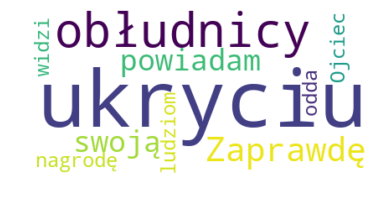

In [72]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, 
                      max_font_size=150, 
                      max_words=10, 
                      background_color="white").generate(clean_text(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Statystyki

#### Term frequency

In [73]:
fdist = nltk.probability.FreqDist(txt)

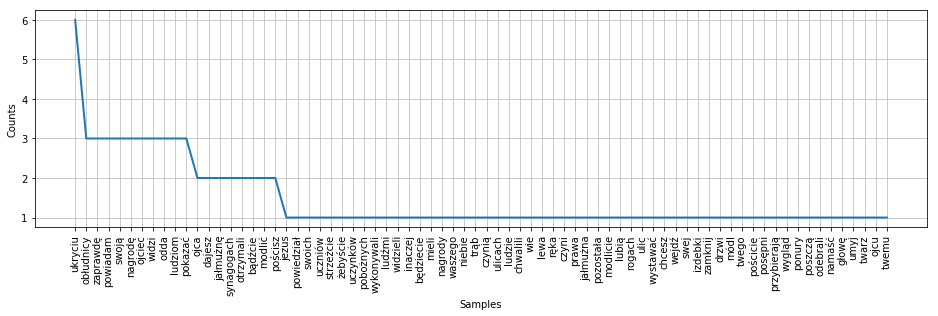

In [74]:
plt.figure(figsize=(16,4))
fdist_plot = fdist.plot()
plt.show()

In [75]:
#occurs only once
print(fdist.hapaxes())

['jezus', 'powiedział', 'swoich', 'uczniów', 'strzeżcie', 'żebyście', 'uczynków', 'pobożnych', 'wykonywali', 'ludźmi', 'widzieli', 'inaczej', 'będziecie', 'mieli', 'nagrody', 'waszego', 'niebie', 'trąb', 'czynią', 'ulicach', 'ludzie', 'chwalili', 'wie', 'lewa', 'ręka', 'czyni', 'prawa', 'jałmużna', 'pozostała', 'modlicie', 'lubią', 'rogach', 'ulic', 'wystawać', 'chcesz', 'wejdź', 'swej', 'izdebki', 'zamknij', 'drzwi', 'módl', 'twego', 'pościcie', 'posępni', 'przybierają', 'wygląd', 'ponury', 'poszczą', 'odebrali', 'namaść', 'głowę', 'umyj', 'twarz', 'ojcu', 'twemu']


In [76]:
def lexical_diversity(text):
    return len(text)/len(set(text))

def percentage(count,total):
    return 100 * count/total

In [77]:
lexical_diversity(text)

27.043478260869566

In [78]:
percentage(text.count(bow.most_common(1)[0][0]),len(text))

0.48231511254019294

In [79]:
#to fix
#text.dispersion_plot(keys)

### N-Grams

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

In [81]:
#PL
ngram_vect = CountVectorizer(ngram_range=(2,2))
X_counts = ngram_vect.fit_transform(df_cleaned['Ewangelia'].apply(lambda x: clean_text(x)))

print(X_counts.shape)
print(ngram_vect.get_feature_names()[:10])

(130, 11445)
['abraham nie', 'abraham odparł', 'abraham odrzekł', 'abraham ojciec', 'abraham rzekł', 'abraham stał', 'abraham umarł', 'abrahama ale', 'abrahama który', 'abrahama nigdy']


In [82]:
X_ngram_df = pd.DataFrame(X_counts.toarray())
X_ngram_df.columns = ngram_vect.get_feature_names()
X_ngram_df

,abraham nie,abraham odparł,abraham odrzekł,abraham ojciec,abraham rzekł,abraham stał,abraham umarł,abrahama ale,abrahama który,abrahama nigdy,...,żywi czyż,żywiły się,żywności dla,żywność bo,żywym który,żyć będą,żył na,żył pewien,żył przeze,żąda znaku
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
#ENG
ngram_vect = CountVectorizer(ngram_range=(2,2))
X_counts = ngram_vect.fit_transform(df_eng['Ewangelia'].apply(lambda x: clean_text(x)))

print(X_counts.shape)
print(ngram_vect.get_feature_names()[:10])

(20, 2437)
['abandoned the', 'abiathar the', 'able to', 'about all', 'about him', 'about how', 'about the', 'above the', 'absolute certainty', 'accept it']


In [84]:
X_ngram_df = pd.DataFrame(X_counts.toarray())
X_ngram_df.columns = ngram_vect.get_feature_names()
X_ngram_df

,abandoned the,abiathar the,able to,about all,about him,about how,about the,above the,absolute certainty,accept it,...,your people,your salvation,your servant,your sins,your soul,your word,yourself to,zajordania and,zebedee and,zebedee followed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
#PL
ngram_vect_p = CountVectorizer(ngram_range=(2,2))
X_counts_p = ngram_vect_p.fit_transform(df_p['Tekst'])

print(X_counts_p.shape)
print(ngram_vect_p.get_feature_names()[:10])

(186, 6821)
['abba ojcze', 'abrahama izaaka', 'abrahama pomny', 'abrahama wykrzykujcie', 'abrahamowi jego', 'aby każdy', 'aby nami', 'aby nas', 'aby niewinnie', 'aby twój']


In [86]:
#ENG
ngram_vect_p = CountVectorizer(ngram_range=(2,2))
X_counts_p = ngram_vect_p.fit_transform(df_p_eng['Tekst'])

print(X_counts_p.shape)
print(ngram_vect_p.get_feature_names()[:10])

(186, 6821)
['abba ojcze', 'abrahama izaaka', 'abrahama pomny', 'abrahama wykrzykujcie', 'abrahamowi jego', 'aby każdy', 'aby nami', 'aby nas', 'aby niewinnie', 'aby twój']


### Tf-idf 

#### Term frequency - inverse document frequency
Ważenie częstością termów - odwrotna częstość w dokumentach - jedna z metod obliczania wagi słów w oparciu o liczbę ich wystąpień, należąca do grupy algorytmów obliczających statystyczne wagi termów. 
- Każdy dokument reprezentowany jest przez wektor, składający się z wag słów występujących w tym dokumencie. 
- TFIDF informuje o częstości wystąpienia termów uwzględniając jednocześnie odpowiednie wyważenie znaczenia lokalnego termu i jego znaczenia w kontekście pełnej kolekcji dokumentów. 

https://pl.wikipedia.org/wiki/TFIDF

- Pozwala na określenie rzadkich, ale ważnych słów każdym dokumencie

$$w(i,j) = tf(i,j) * log(\frac{N}{df(i)})$$

gdzie:

>* w(i,f) - waga tokenu i w dokumencie j
>* tf(i,j) - liczba wystąpień tokenu i w dokumencie j
>* df(i) - licza dokumentów zawierających token i
>*N - liczba wszystkich dokumentów

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [88]:
#PL
tfidf_vect = TfidfVectorizer(analyzer=clean_text3)
X_tfidf = tfidf_vect.fit_transform(df_raw['Ewangelia'].apply(lambda x: clean_text(x)))
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names()[:10])

(130, 3992)
['', 'A', 'Abraham', 'Abrahama', 'Abrahamie', 'Abrahamowi', 'Albo', 'Albowiem', 'Ale', 'Ani']


In [89]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns = tfidf_vect.get_feature_names()
X_tfidf_df

,,A,Abraham,Abrahama,Abrahamie,Abrahamowi,Albo,Albowiem,Ale,Ani,...,żyjący,żyję,żywego,żywi,żywiły,żywności,żywność,żywym,żyć,żył
0,0.024359,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.041168,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.048593,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.066486,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.039567,0.034636,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.066938,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,0.054591,0.095576,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
6,0.054075,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
7,0.032942,0.028837,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
8,0.040220,0.070416,0.000000,0.000000,0.000000,0.0,0.000000,0.083844,0.000000,0.000000,...,0.0,0.0,0.118131,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9,0.046393,0.040611,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [90]:
tfidf_vect_eng = TfidfVectorizer(analyzer=clean_text3)
X_tfidf_eng = tfidf_vect_eng.fit_transform(df_eng['Ewangelia'].apply(lambda x: clean_text(x)))
print(X_tfidf_eng.shape)
print(tfidf_vect_eng.get_feature_names()[:10])

(20, 850)
['', 'A', 'Abiathar', 'After', 'All', 'Alphaeus', 'Also', 'And', 'Andrzej', 'Anna']


In [91]:
X_tfidf_df_eng = pd.DataFrame(X_tfidf_eng.toarray())
X_tfidf_df_eng.columns = tfidf_vect_eng.get_feature_names()
X_tfidf_df_eng

,,A,Abiathar,After,All,Alphaeus,Also,And,Andrzej,Anna,...,year,years,yet,yield,yielded,yields,you,young,your,yourself
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031656,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.083408,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048121,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202251,0.000000,0.000000,0.000000
2,0.034080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.097841,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.042966,0.042966,0.000000,0.051403,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.082824,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043513,0.000000,0.063980,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.074684,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033882,0.000000,0.000000,0.000000
5,0.000000,0.061351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.069795,0.000000,0.000000,0.000000,0.000000,0.000000,0.111332,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.290357,0.000000,0.053366,0.000000
7,0.086802,0.000000,0.000000,0.086802,0.000000,0.000000,0.000000,0.041534,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111137,0.042179,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080739,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062369,0.000000


### Sentiment analysis

In [92]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [93]:
sid = SentimentIntensityAnalyzer()

ss = sid.polarity_scores(text)

In [94]:
print(ss)

{'neg': 0.019, 'neu': 0.941, 'pos': 0.04, 'compound': 0.4939}


In [95]:
text

'Jezus powiedział do swoich uczniów: „Strzeżcie się, żebyście uczynków pobożnych nie wykonywali przed ludźmi po to, aby was widzieli; inaczej nie będziecie mieli nagrody u Ojca waszego, który jest w niebie. Kiedy więc dajesz jałmużnę, nie trąb przed sobą, jak obłudnicy czynią w synagogach i na ulicach, aby ich ludzie chwalili. Zaprawdę powiadam wam: ci otrzymali już swoją nagrodę. Kiedy zaś ty dajesz jałmużnę, niech nie wie lewa twoja ręka, co czyni prawa, aby twoja jałmużna pozostała w ukryciu. A Ojciec twój który widzi w ukryciu, odda tobie. Gdy się modlicie, nie bądźcie jak obłudnicy. Oni lubią w synagogach i na rogach ulic wystawać i modlić się, żeby się ludziom pokazać. Zaprawdę powiadam wam: otrzymali już swoją nagrodę. Ty zaś gdy chcesz się modlić, wejdź do swej izdebki, zamknij drzwi i módl się do Ojca twego, który jest w ukryciu. A Ojciec twój, który widzi w ukryciu, odda tobie. Kiedy pościcie, nie bądźcie posępni jak obłudnicy. Przybierają oni wygląd ponury, aby pokazać ludzi

### Metadane
#### Okres:
- adwent
- Boże Narodzenie
- okres zwykły
- Wielki Post
- okres wielkanocny

#### Sentyment / wydźwięk:
- neutralny
- pozytywny
- negatywny

#### Statystyki:
- liczba słów w całym tekście
- liczba słów pojawiających się tylko raz (hapaxes)
- zróżnicowane językowe
- jaki % stanowią najczęściej występujące słowa

# TO DO:
- word2vec
- glove

### Similarity

In [96]:
df_readings.head()

,Dzień tygodnia,Pierwsze czytanie,Psalm_ref,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia
2019-02-03,Sunday,Za panowania Jozjasza Pan skierował do mnie na...,"Będę wysławiał pomoc Twoją, Panie","W Tobie, Panie, ucieczka moja, niech wstydu ni...","Starajcie się o większe dary, a ja wam wskażę ...","Pan posłał Mnie, abym ubogim niósł dobrą now...","Kiedy Jezus przyszedł do Nazaretu, przemówił d..."
2019-02-02,Saturday,"To mówi Pan Bóg: ""Oto Ja wyślę anioła mego, ab...","Pan Bóg Zastępów, On jest Królem chwały","Bramy, podnieście swe szczyty, unieście się, o...","Ponieważ dzieci uczestniczą we krwi i ciele, d...",Światło na oświecenie pogan i chwała ludu Tw...,Gdy upłynęły dni oczyszczenia Maryi według Pra...
2019-02-01,Friday,"Przypomnijcie sobie dawniejsze dni, kiedy to p...",Zbawienie prawych pochodzi od Pana,"Miej ufność w Panu i czyń to, co dobre, a będz...",None,"Wysławiam Cię, Ojcze, Panie nieba i ziemi, ż...","Jezus mówił do tłumów: ""Z królestwem Bożym dzi..."
2019-01-31,Thursday,"Bracia, mamy pewność, iż wejdziemy do Miejsca ...","Oto lud wierny, szukający Boga","Do Pana należy ziemia i wszystko, co ją napełn...",None,", 105) Twoje słowo jest pochodnią dla stóp mo...","Jezus mówił ludowi: ""Czy po to wnosi się świat..."
2019-01-30,Wednesday,Każdy kapłan Starego Testamentu staje codzienn...,"Jesteś kapłanem, tak jak Melchizedek","Rzekł Pan do Pana mego: ""Siądź po mojej prawic...",None,"Ziarnem jest słowo Boże, a siewcą jest Chrys...",Jezus znowu zaczął nauczać nad jeziorem i bard...


In [97]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [101]:
doc1 = nlp(df_readings.loc['2019-02-01']['Ewangelia'])
doc2 = nlp(df_readings.loc['2019-01-30']['Ewangelia'])
doc3 = nlp(df_readings.loc['2019-01-29']['Ewangelia'])

In [102]:
doc1

Jezus mówił do tłumów: "Z królestwem Bożym dzieje się tak, jak gdyby ktoś nasienie wrzucił w ziemię. Czy śpi, czy czuwa, we dnie i w nocy, nasienie kiełkuje i rośnie, sam nie wie jak. Ziemia sama z siebie wydaje plon, najpierw źdźbło, potem kłos, a potem pełne ziarno w kłosie. Gdy zaś plon dojrzeje, zaraz zapuszcza sierp, bo pora już na żniwo". Mówił jeszcze: "Z czym porównamy królestwo Boże lub w jakiej przypowieści je przedstawimy? Jest ono jak ziarnko gorczycy; gdy się je wsiewa w ziemię, jest najmniejsze ze wszystkich nasion na ziemi. Lecz wsiane, wyrasta i staje się większe od innych jarzyn; wypuszcza wielkie gałęzie, tak że ptaki podniebne gnieżdżą się w jego cieniu". W wielu takich przypowieściach głosił im naukę, o ile mogli ją rozumieć. A bez przypowieści nie przemawiał do nich. Osobno zaś objaśniał wszystko swoim uczniom.

In [103]:
doc3

Nadeszła Matka Jezusa i bracia i stojąc na dworze, posłali po Niego, aby Go przywołać. A tłum ludzi siedział wokół Niego, gdy Mu powiedzieli: "Oto Twoja Matka i bracia na dworze szukają Ciebie". Odpowiedział im: "Któż jest moją matką i którzy są moimi braćmi?" I spoglądając na siedzących dokoła Niego, rzekł: "Oto moja matka i moi bracia. Bo kto pełni wolę Bożą, ten jest Mi bratem, siostrą i matką".

In [104]:
doc1.similarity(doc3)

0.8739011263424964